In [13]:
import tensorflow as tf

# --- Rutas ---
train_dir = "C:/Users/aserr/Downloads/002.Cancer/train"
test_dir  = "C:/Users/aserr/Downloads/002.Cancer/test"

# --- Parámetros ---
img_height, img_width = 224, 224
batch_size = 32

# --- Preprocesamiento ---
def preprocess_tensor(img, label):
    # Redimensionar
    img = tf.image.resize(img, [img_height, img_width])
    # Normalizar a [0,1]
    img = img / 255.0
    return img, label

# --- Dataset de entrenamiento + validación ---
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    batch_size=None,  # sin batching para poder separar
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123
)

# Split en train y validación (80/20)
train_size = int(0.8 * len(full_train_ds))
val_size = len(full_train_ds) - train_size

train_ds = full_train_ds.take(train_size)
val_ds   = full_train_ds.skip(train_size)

# Preprocesar
train_ds = train_ds.map(preprocess_tensor, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess_tensor, num_parallel_calls=tf.data.AUTOTUNE)

# Batch + Prefetch
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# --- Dataset de test ---
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    batch_size=None,
    image_size=(img_height, img_width),
    shuffle=False
)
test_ds = test_ds.map(preprocess_tensor, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("✅ Train, validación y test listos")


Found 11879 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
✅ Train, validación y test listos


## 1. CNN Sencilla

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

# --- Definir modelo CNN simple ---
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # salida binaria (maligno/benigno)
])

# --- Compilar ---
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- Entrenar ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# --- Evaluar en test ---
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Precisión en test: {test_acc:.2f}")


Epoch 1/10


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 65s 215ms/step - accuracy: 0.7630 - loss: 0.5073 - val_accuracy: 0.8165 - val_loss: 0.3721
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 65s 220ms/step - accuracy: 0.8252 - loss: 0.3970 - val_accuracy: 0.8190 - val_loss: 0.3842
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - accuracy: 0.8384 - loss: 0.3720 - val_accuracy: 0.8628 - val_loss: 0.3328
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 210ms/step - accuracy: 0.8459 - loss: 0.3565 - val_accuracy: 0.8519 - val_loss: 0.3378
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - accuracy: 0.8493 - loss: 0.3475 - val_accuracy: 0.8468 - val_loss: 0.3280
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - accuracy: 0.8574 - loss: 0.3338 - val_accuracy: 0.8666 - val_loss: 0.3127
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 60s 203ms/step - accuracy: 0.8562 - loss: 0.3215 - val_accuracy: 0.8708 - val_loss: 0.3030
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 60s 203ms/step - accuracy: 0.8571 - loss: 0.3201 - val

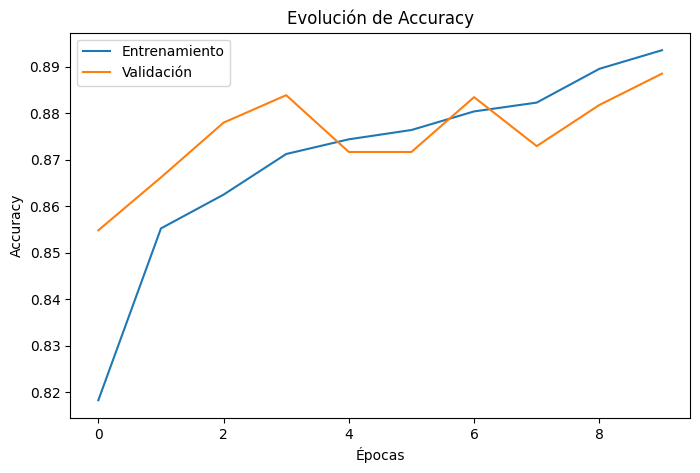

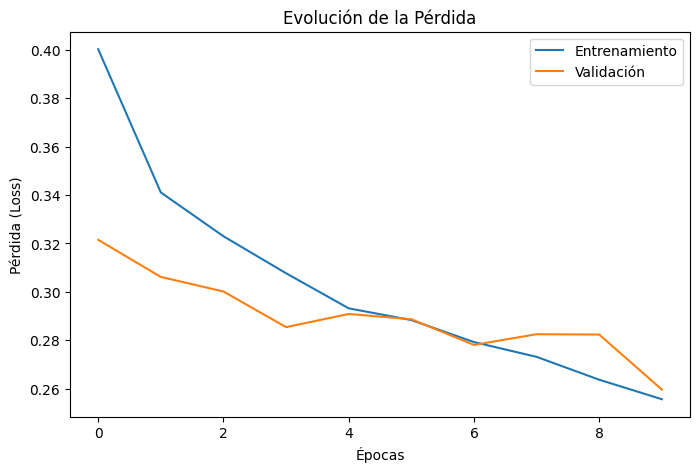

In [19]:
import matplotlib.pyplot as plt

# --- Curvas de Accuracy ---
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.title('Evolución de Accuracy')
plt.legend()
plt.show()

# --- Curvas de Loss ---
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.title('Evolución de la Pérdida')
plt.legend()
plt.show()


## 2. Transfer Learning (más potente)

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# --- Base preentrenada ---
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # congelar capas

# --- Modelo completo ---
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# --- Compilar ---
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- Entrenar ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# --- Evaluar ---
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Precisión en test: {test_acc:.2f}")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 65s 213ms/step - accuracy: 0.8183 - loss: 0.4003 - val_accuracy: 0.8548 - val_loss: 0.3215
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 209ms/step - accuracy: 0.8552 - loss: 0.3411 - val_accuracy: 0.8662 - val_loss: 0.3062
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 209ms/step - accuracy: 0.8625 - loss: 0.3230 - val_accuracy: 0.8779 - val_loss: 0.3002
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 208ms/step - accuracy: 0.8712 - loss: 0.3077 - val_accuracy: 0.8838 - val_loss: 0.2854
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 207ms/step - accuracy: 0.8744 - loss: 0.2932 - val_accuracy: 0.8716 - val_loss: 0.2909
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 207ms/step - accuracy: 0.8764 - loss: 0.2883 - val_accuracy: 0.8716 - val_loss: 0.2887
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 209ms/step - accuracy: 0.8804 - loss: 0.2792 - val_accuracy: 0.8834 - val_loss: 0.2781
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━

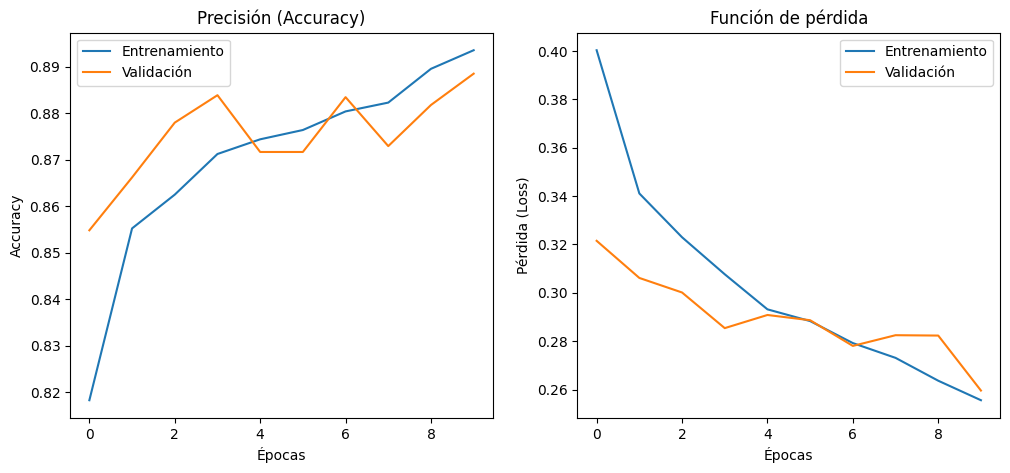

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step


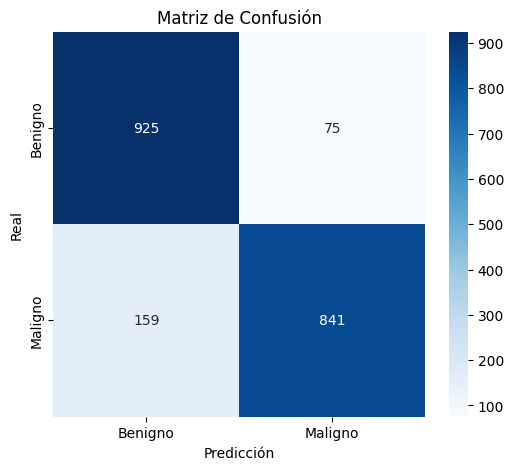

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# --- Gráfico de Accuracy y Loss ---
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Precisión (Accuracy)")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.title("Función de pérdida")
plt.legend()

plt.show()

# --- Matriz de confusión ---
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benigno", "Maligno"],
            yticklabels=["Benigno", "Maligno"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


## 1.2

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 206ms/step - accuracy: 0.6582 - loss: 0.6251 - val_accuracy: 0.7748 - val_loss: 0.4993
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 63s 213ms/step - accuracy: 0.7516 - loss: 0.5068 - val_accuracy: 0.8232 - val_loss: 0.4399
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - accuracy: 0.7904 - loss: 0.4726 - val_accuracy: 0.8199 - val_loss: 0.4206
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - accuracy: 0.8121 - loss: 0.4432 - val_accuracy: 0.8173 - val_loss: 0.4347
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 206ms/step - accuracy: 0.8121 - loss: 0.4367 - val_accuracy: 0.8455 - val_loss: 0.3900
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 204ms/step - accuracy: 0.8238 - loss: 0.4144 - val_accuracy: 0.8472 - val_loss: 0.3619
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - accuracy: 0.8308 - loss: 0.3925 - val_accuracy: 0.8527 - val_loss: 0.3451
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 208ms/step - accuracy: 0.8378 - loss: 0

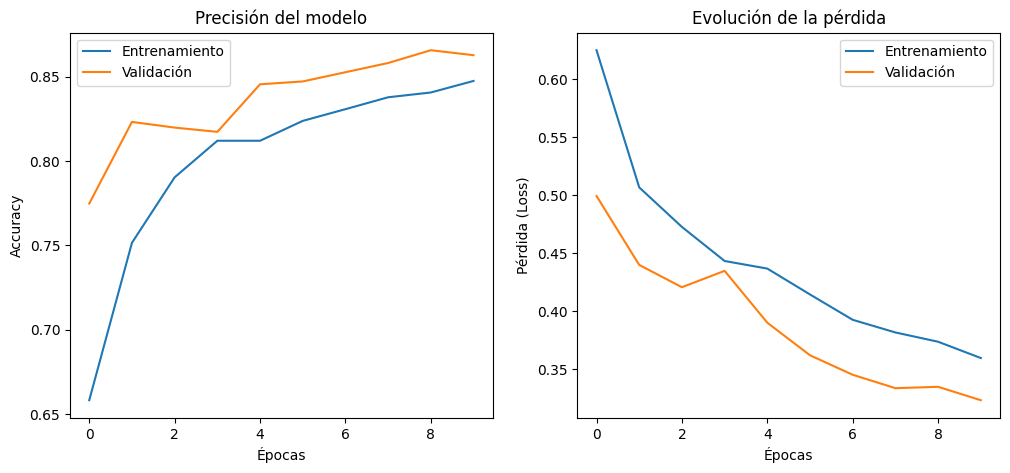

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step


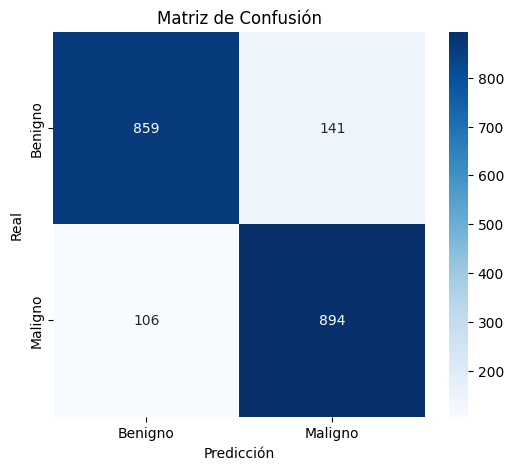


📋 Classification Report:

              precision    recall  f1-score   support

     Benigno       0.89      0.86      0.87      1000
     Maligno       0.86      0.89      0.88      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


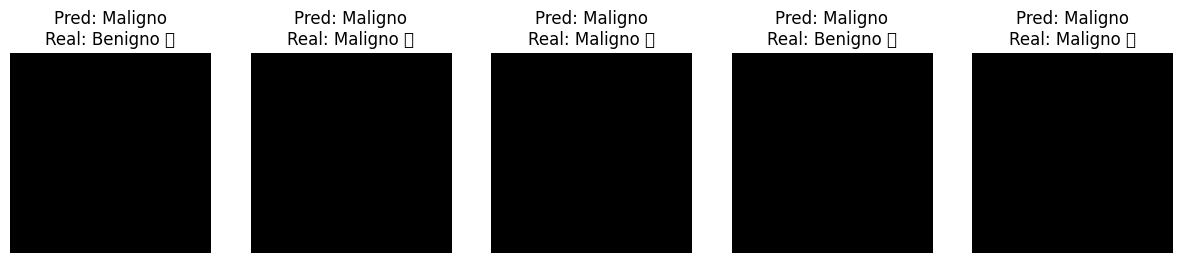

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random

# --- Modelo CNN mejorado ---
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # salida binaria
])

# --- Compilar ---
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- Entrenar ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# --- Evaluar en test ---
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Precisión en test: {test_acc:.2f}")

# ============================
# 1️⃣ Gráficas de Accuracy y Loss
# ============================
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Precisión del modelo")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.title("Evolución de la pérdida")
plt.legend()

plt.show()

# ============================
# 2️⃣ Matriz de Confusión
# ============================
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benigno", "Maligno"],
            yticklabels=["Benigno", "Maligno"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Benigno", "Maligno"]))

# ============================
# 3️⃣ Mostrar 5 imágenes aleatorias con predicción
# ============================
class_names = ["Benigno", "Maligno"]

# Tomamos todas las imágenes y labels del test
images_all = np.concatenate([x.numpy() for x, _ in test_ds], axis=0)
labels_all = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Elegir 5 índices aleatorios
indices = random.sample(range(len(images_all)), 5)

plt.figure(figsize=(15,5))
for i, idx in enumerate(indices):
    img = images_all[idx]
    label = labels_all[idx]
    pred_prob = model.predict(img[np.newaxis, ...])[0][0]
    pred_class = int(pred_prob > 0.5)
    correcto = "✅" if pred_class == label else "❌"
    
    plt.subplot(1,5,i+1)
    plt.imshow(img.astype("uint8"))
    plt.axis("off")
    plt.title(f"Pred: {class_names[pred_class]}\nReal: {class_names[label]} {correcto}")

plt.show()


In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- Rutas ---
train_dir = "C:/Users/aserr/Downloads/002.Cancer/train"
test_dir  = "C:/Users/aserr/Downloads/002.Cancer/test"

# --- Parámetros ---
img_height, img_width = 224, 224
batch_size = 32

# --- Preprocesamiento ---
def preprocess_image(img, label):
    # Redimensionar
    img = tf.image.resize(img, [img_height, img_width])
    
    # Normalización RGB a [0,1]
    img = img / 255.0
    
    # Suavizado con filtro Gaussiano (usando tf.image.stateless_random_contrast como aproximación)
    # Nota: tf no tiene GaussianBlur nativo sin tf.py_function, así que este paso se puede omitir para entrenamiento
    return img, label

# --- Dataset entrenamiento + validación ---
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, labels="inferred", label_mode="int",
    image_size=(img_height, img_width), shuffle=True, seed=123, batch_size=None
)

train_size = int(0.8 * len(full_train_ds))
train_ds = full_train_ds.take(train_size)
val_ds   = full_train_ds.skip(train_size)

train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# --- Dataset test ---
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, labels="inferred", label_mode="int",
    image_size=(img_height, img_width), shuffle=False, batch_size=None
)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

Found 11879 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2



# ============================
# Modelo CNN mejorado
# ============================
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- Entrenar ---
history = model.fit(train_ds, validation_data=val_ds, epochs=26)

# --- Evaluar en test ---
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Precisión en test: {test_acc:.2f}")

Epoch 1/26


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 73s 243ms/step - accuracy: 0.7693 - loss: 0.4936 - val_accuracy: 0.8304 - val_loss: 0.3733
Epoch 2/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 70s 235ms/step - accuracy: 0.8213 - loss: 0.4044 - val_accuracy: 0.8363 - val_loss: 0.3435
Epoch 3/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 71s 238ms/step - accuracy: 0.8366 - loss: 0.3677 - val_accuracy: 0.8043 - val_loss: 0.3883
Epoch 4/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 76s 256ms/step - accuracy: 0.8468 - loss: 0.3503 - val_accuracy: 0.8531 - val_loss: 0.3366
Epoch 5/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 69s 233ms/step - accuracy: 0.8537 - loss: 0.3390 - val_accuracy: 0.8674 - val_loss: 0.3086
Epoch 6/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 69s 233ms/step - accuracy: 0.8560 - loss: 0.3357 - val_accuracy: 0.8725 - val_loss: 0.3055
Epoch 7/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 69s 232ms/step - accuracy: 0.8593 - loss: 0.3156 - val_accuracy: 0.8594 - val_loss: 0.3088
Epoch 8/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 69s 233ms/step - accuracy: 0.8563 - loss: 0.3264 - val

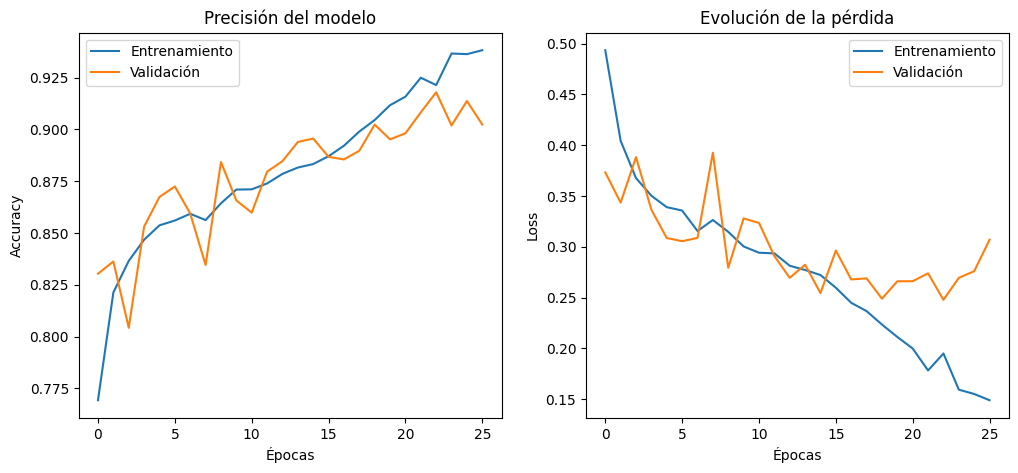

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step


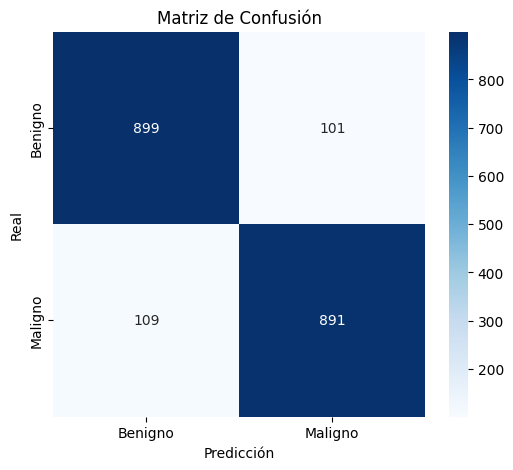


📋 Classification Report:

              precision    recall  f1-score   support

     Benigno       0.89      0.90      0.90      1000
     Maligno       0.90      0.89      0.89      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.89      2000
weighted avg       0.90      0.90      0.89      2000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


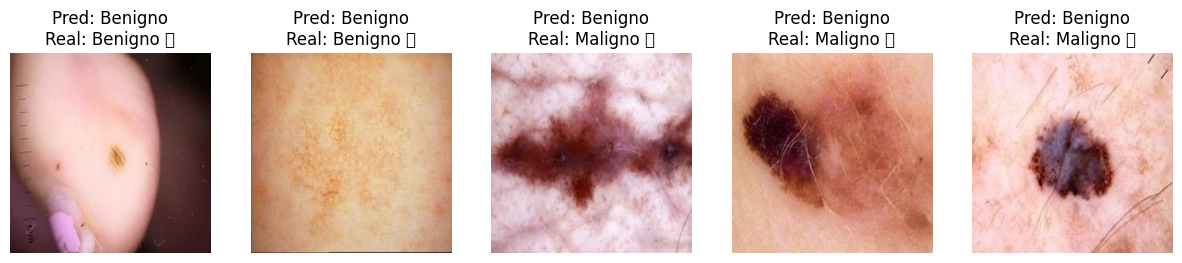

In [20]:

# ============================
# Gráficas de Accuracy y Loss
# ============================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Precisión del modelo")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Evolución de la pérdida")
plt.legend()
plt.show()

# ============================
# Matriz de confusión
# ============================
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benigno","Maligno"],
            yticklabels=["Benigno","Maligno"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Benigno","Maligno"]))

# ============================
# Mostrar 5 imágenes aleatorias con predicción
# ============================
class_names = ["Benigno", "Maligno"]

# Concatenar todos los batches
images_list, labels_list = [], []
for imgs, labels in test_ds:
    images_list.append(imgs.numpy())
    labels_list.append(labels.numpy())

images_all = np.concatenate(images_list, axis=0)
labels_all = np.concatenate(labels_list, axis=0)

# Desnormalizar para mostrar
images_all_disp = (images_all * 255).astype("uint8")

indices = np.random.choice(len(images_all_disp), size=5, replace=False)

plt.figure(figsize=(15,5))
for i, idx in enumerate(indices):
    img = images_all_disp[idx]
    label = labels_all[idx]
    
    # Predecir
    pred_prob = model.predict(img[np.newaxis, ...])[0][0]
    pred_class = int(pred_prob > 0.5)
    correcto = "✅" if pred_class == label else "❌"
    
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {class_names[pred_class]}\nReal: {class_names[label]} {correcto}")

plt.show()


## Con colores.

In [30]:
import tensorflow as tf
import numpy as np
import cv2

# ----------------------------
# Parámetros de imagen
# ----------------------------
img_height = 224
img_width  = 224
batch_size = 32

# ----------------------------
# Rutas de los datasets
# ----------------------------
train_dir = r"C:\Users\aserr\Downloads\002.Cancer\train"
test_dir  = r"C:\Users\aserr\Downloads\002.Cancer\test"

# ----------------------------
# Funciones de preprocesado
# ----------------------------
def apply_heatmap_safe(img_tensor):
    img = img_tensor.numpy()
    img = (img * 255).astype('uint8')
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    heatmap = cv2.applyColorMap(img_gray, cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (img_width, img_height))
    heatmap = heatmap.astype('float32') / 255.0
    return heatmap

def preprocess_with_heatmap(img, label):
    img = tf.image.resize(img, [img_height, img_width])
    img = img / 255.0

    def heat():
        return tf.py_function(apply_heatmap_safe, [img], Tout=tf.float32)

    # 40% de imágenes en heatmap
    img_final = tf.cond(tf.random.uniform([]) < 0.4, heat, lambda: img)
    img_final.set_shape([img_height, img_width, 3])
    return img_final, label

# ----------------------------
# Cargar dataset de entrenamiento
# ----------------------------
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    batch_size=None
)

# Crear validación a partir del train (80% train, 20% val)
train_size = int(0.8 * len(full_train_ds))
train_ds = full_train_ds.take(train_size)
val_ds   = full_train_ds.skip(train_size)

# Aplicar preprocesado con heatmaps
train_ds = train_ds.map(preprocess_with_heatmap, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess_with_heatmap, num_parallel_calls=tf.data.AUTOTUNE)

# Preparar batches y prefetch
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ----------------------------
# Dataset de test
# ----------------------------
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=(img_height, img_width),
    shuffle=False,
    batch_size=None
)

test_ds = test_ds.map(preprocess_with_heatmap, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("✅ Dataset listo con 40% de imágenes en heatmap")


Found 11879 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
✅ Dataset listo con 40% de imágenes en heatmap


Class weights: {0: np.float64(0.9440691436518974), 1: np.float64(1.0629753914988815)}
Epoch 1/22


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 173s 579ms/step - accuracy: 0.6913 - loss: 0.5787 - val_accuracy: 0.7391 - val_loss: 0.5150
Epoch 2/22
297/297 ━━━━━━━━━━━━━━━━━━━━ 168s 567ms/step - accuracy: 0.7747 - loss: 0.4654 - val_accuracy: 0.7866 - val_loss: 0.4362
Epoch 3/22
297/297 ━━━━━━━━━━━━━━━━━━━━ 169s 568ms/step - accuracy: 0.8011 - loss: 0.4224 - val_accuracy: 0.8178 - val_loss: 0.3824
Epoch 4/22
297/297 ━━━━━━━━━━━━━━━━━━━━ 169s 568ms/step - accuracy: 0.8174 - loss: 0.3916 - val_accuracy: 0.8304 - val_loss: 0.3640
Epoch 5/22
297/297 ━━━━━━━━━━━━━━━━━━━━ 169s 567ms/step - accuracy: 0.8330 - loss: 0.3692 - val_accuracy: 0.8384 - val_loss: 0.3712
Epoch 6/22
297/297 ━━━━━━━━━━━━━━━━━━━━ 169s 568ms/step - accuracy: 0.8432 - loss: 0.3483 - val_accuracy: 0.8472 - val_loss: 0.3359
Epoch 7/22
297/297 ━━━━━━━━━━━━━━━━━━━━ 169s 569ms/step - accuracy: 0.8566 - loss: 0.3301 - val_accuracy: 0.8594 - val_loss: 0.3140
Epoch 8/22
297/297 ━━━━━━━━━━━━━━━━━━━━ 170s 571ms/step - accuracy: 0.8725 - loss: 0.29

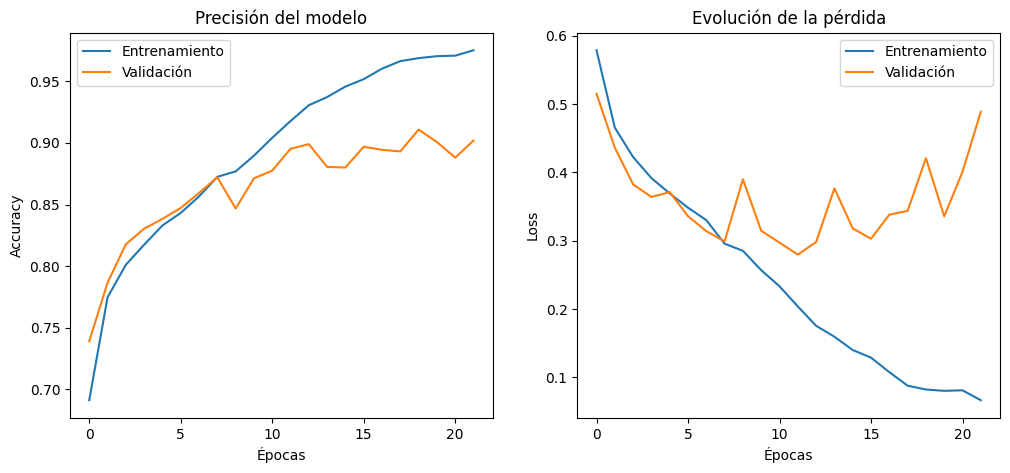

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step


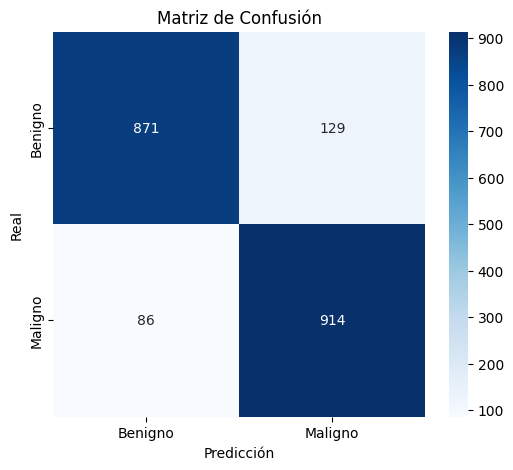

              precision    recall  f1-score   support

     Benigno       0.91      0.87      0.89      1000
     Maligno       0.88      0.91      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


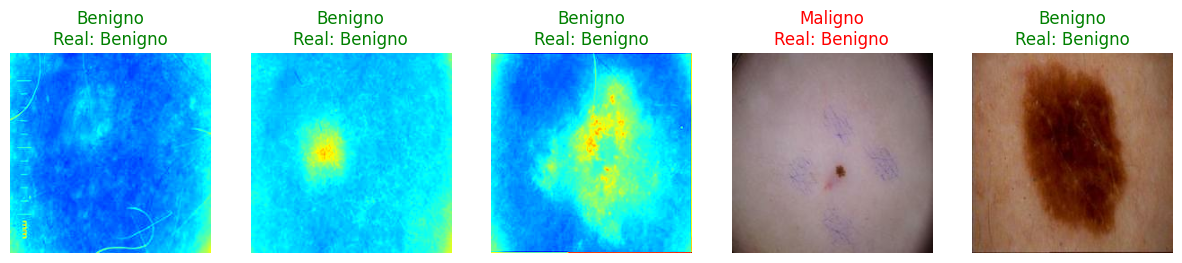

✅ Modelo guardado como modelo_cnn.h5


In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import cv2


# ----------------------------
# Calcular pesos de clase para balancear
# ----------------------------
y_train = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

# ----------------------------
# Crear modelo CNN (como tu versión original)
# ----------------------------
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ----------------------------
# Entrenamiento
# ----------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=22,
    class_weight=class_weights
)

# ----------------------------
# Evaluación en test
# ----------------------------
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Precisión en test: {test_acc:.2f}")

# ----------------------------
# Gráficas de Accuracy y Loss
# ----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Precisión del modelo")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Evolución de la pérdida")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ----------------------------
# Matriz de confusión y reporte
# ----------------------------
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds)
threshold = 0.4
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

# ----------------------------
# Mostrar 5 imágenes aleatorias con predicción
# ----------------------------
plt.figure(figsize=(15,6))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_classes = (preds > threshold).astype("int32").flatten()
    
    indices = random.sample(range(len(images)), 5)
    for i, idx in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow(images[idx].numpy())
        plt.axis("off")
        color_warning = "red" if preds_classes[idx] == 1 else "green"
        plt.title(f"{class_names[preds_classes[idx]]}\nReal: {class_names[int(labels[idx])]}", color=color_warning)
plt.show()

# ----------------------------
# Guardar modelo
# ----------------------------
model.save("modelo_cnn.h5")
print("✅ Modelo guardado como modelo_cnn.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


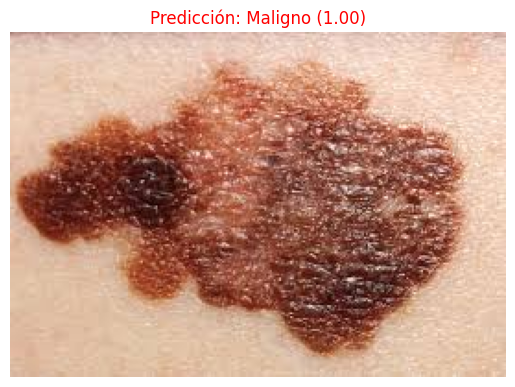

👉 Resultado: Maligno con probabilidad 1.00


In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# ============================
# Función para analizar imagen
# ============================
def analizar_imagen(ruta_imagen, model, img_height=224, img_width=224, threshold=0.4):
    # Cargar la imagen
    img = tf.keras.utils.load_img(ruta_imagen, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)

    # Normalizar a [0,1]
    img_array = img_array / 255.0

    # Añadir dimensión batch
    img_array = np.expand_dims(img_array, axis=0)

    # Predicción
    pred = model.predict(img_array)[0][0]

    # Clasificación
    clase = "Maligno" if pred > threshold else "Benigno"

    # Mostrar resultado
    plt.imshow(tf.keras.utils.load_img(ruta_imagen))
    plt.axis("off")
    plt.title(f"Predicción: {clase} ({pred:.2f})", color="red" if clase=="Maligno" else "green")
    plt.show()

    return clase, pred

# ============================
# Uso de la función
# ============================
ruta = "C:/Users/aserr/Downloads/FotoMelanoma1.jpeg"  # <-- pon aquí la ruta de tu imagen
clase, prob = analizar_imagen(ruta, model)
print(f"👉 Resultado: {clase} con probabilidad {prob:.2f}")


Otro modelo 


Epoch 1/30


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 75s 246ms/step - accuracy: 0.6773 - loss: 0.6675 - val_accuracy: 0.7723 - val_loss: 0.5053
Epoch 2/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 71s 237ms/step - accuracy: 0.7564 - loss: 0.5290 - val_accuracy: 0.7828 - val_loss: 0.5209
Epoch 3/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 77s 259ms/step - accuracy: 0.7633 - loss: 0.5127 - val_accuracy: 0.7748 - val_loss: 0.4746
Epoch 4/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 78s 263ms/step - accuracy: 0.7699 - loss: 0.5136 - val_accuracy: 0.8098 - val_loss: 0.4514
Epoch 5/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 76s 255ms/step - accuracy: 0.7725 - loss: 0.5111 - val_accuracy: 0.8127 - val_loss: 0.4611
Epoch 6/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 77s 260ms/step - accuracy: 0.7823 - loss: 0.5097 - val_accuracy: 0.8098 - val_loss: 0.4427
Epoch 7/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 78s 261ms/step - accuracy: 0.7810 - loss: 0.4980 - val_accuracy: 0.8211 - val_loss: 0.4368
Epoch 8/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 77s 259ms/step - accuracy: 0.7807 - loss: 0.5127 - val

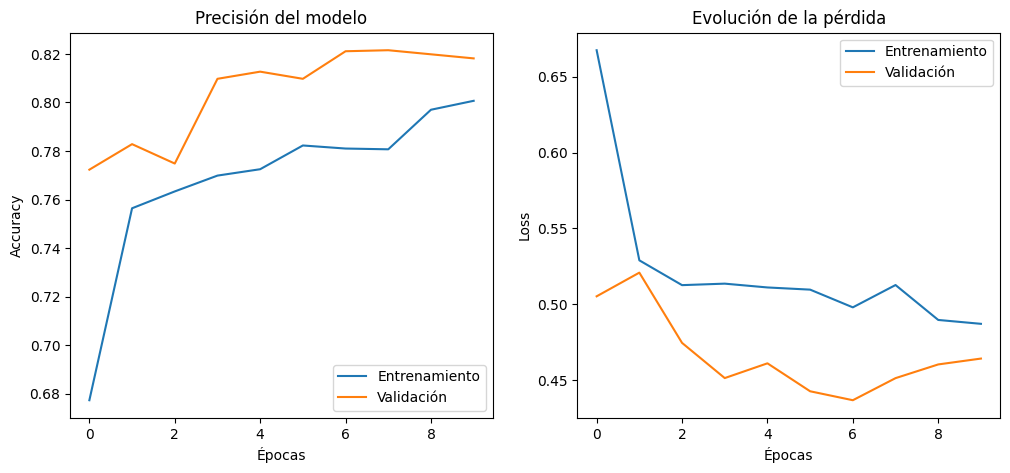

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step


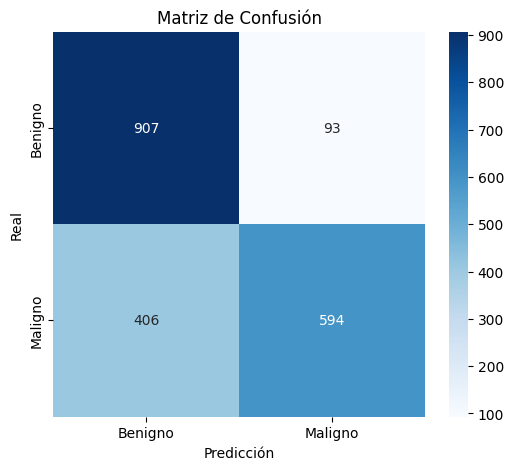

              precision    recall  f1-score   support

     Benigno       0.69      0.91      0.78      1000
     Maligno       0.86      0.59      0.70      1000

    accuracy                           0.75      2000
   macro avg       0.78      0.75      0.74      2000
weighted avg       0.78      0.75      0.74      2000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


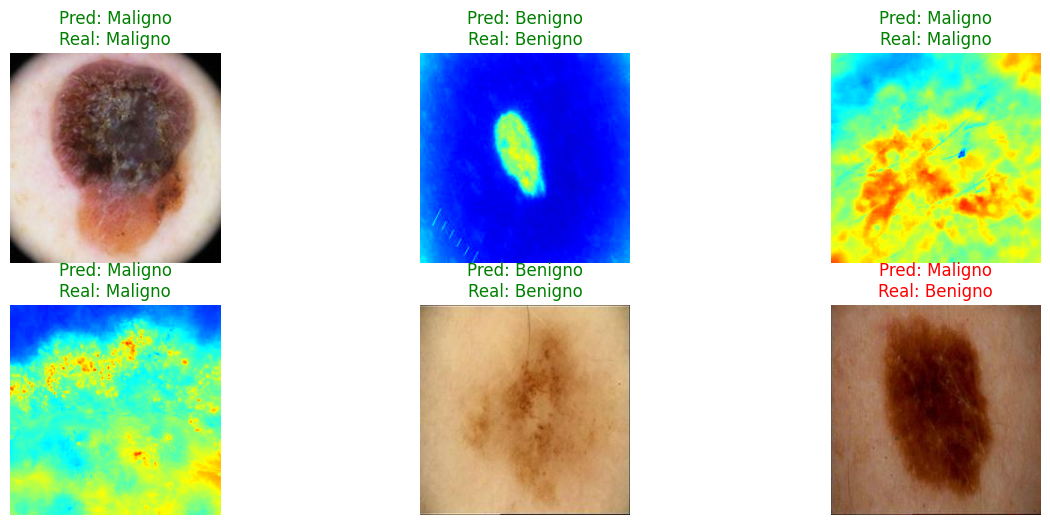

In [8]:
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import random

# ============================
# Data Augmentation
# ============================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# ============================
# Modelo CNN con regularización
# ============================
model = keras.Sequential([
    data_augmentation,  # augmentación antes de las convoluciones

    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu', 
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.6),  # más fuerte
    layers.Dense(1, activation='sigmoid')
])

# ============================
# Compilación
# ============================
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# ============================
# EarlyStopping
# ============================
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ============================
# Entrenamiento
# ============================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

# ============================
# Evaluación
# ============================
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Precisión en test: {test_acc:.2f}")

# ============================
# Gráficas de Accuracy y Loss
# ============================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Precisión del modelo")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Evolución de la pérdida")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ============================
# Matriz de confusión
# ============================
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds)
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benigno", "Maligno"],
            yticklabels=["Benigno", "Maligno"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print(classification_report(y_true, y_pred, target_names=["Benigno", "Maligno"]))

# ============================
# Mostrar ejemplos de ambas clases
# ============================
class_names = ["Benigno", "Maligno"]

benignos = []
malignos = []

# recorremos el test_ds unificado (sin batching)
for img, label in test_ds.unbatch():
    if label.numpy() == 0 and len(benignos) < 3:
        benignos.append((img, label))
    elif label.numpy() == 1 and len(malignos) < 3:
        malignos.append((img, label))
    if len(benignos) >= 3 and len(malignos) >= 3:
        break

# juntamos y mezclamos ejemplos
ejemplos = benignos + malignos
random.shuffle(ejemplos)

plt.figure(figsize=(15,6))
for i, (img, label) in enumerate(ejemplos):
    pred = model.predict(tf.expand_dims(img, axis=0))
    pred_class = (pred > threshold).astype("int32")[0][0]

    plt.subplot(2,3,i+1)
    plt.imshow(img.numpy())
    plt.axis("off")
    color = "green" if pred_class == label.numpy() else "red"
    plt.title(f"Pred: {class_names[pred_class]}\nReal: {class_names[label.numpy()]}",
              color=color)
plt.show()
